# Homework 3

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2025

#### Notation Commands

$$\newcommand{\cpn}{\text{c}}$$
$$\newcommand{\Tunder}{T_\text{bond}}$$
$$\newcommand{\accint}{\xi}$$
$$\newcommand{\convert}{\psi}$$
$$\newcommand{\ctd}{\text{ctd}}$$

$$\newcommand{\refrate}{r^{\text{ref}}}$$
$$\newcommand{\pfwd}{P_{\text{fwd}}}$$
$$\newcommand{\grossbasis}{B}$$
$$\newcommand{\netbasis}{\tilde{\grossbasis}}$$
$$\newcommand{\pnl}{\Pi}$$

$$\newcommand{\years}{\tau}$$
$$\newcommand{\yearsACT}{\years_{\text{act/360}}}$$

$$\newcommand{\fwdprice}{\mathcal{F}_{t\to T}}$$
$$\newcommand{\futprice}{F_{t\to T}}$$

$$\newcommand{\fwdpriceT}{\mathcal{F}_{T\to T}}$$
$$\newcommand{\futpriceT}{F_{T\to T}}$$

$$\newcommand{\fwdpriceDT}{\mathcal{F}_{t+h\to T}}$$
$$\newcommand{\futpriceDT}{F_{t+h\to T}}$$

$$\newcommand{\rrepo}{r^{\text{repo}}}$$
$$\newcommand{\carry}{\widetilde{\cpn}}$$

In [105]:
import pandas as pd
import numpy as np
import datetime
import holidays
import seaborn as sns
import math

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize
from scipy import interpolate
from scipy.optimize import fsolve
from scipy.stats import norm

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import numpy.polynomial.polynomial as poly
# The code here is written with the help of OpenAI's ChatGPT

In [106]:
def calc_fwdswaprate(discounts, Tfwd, Tswap, freqswap):
    "Tfwd = time to the forward exercise date"
    "Tswap = time to swaption expiration date"
    "freqswap = Swap payment frequency"
    
    # Calculate the frequency of discount periods by converting the index to a series,
    # finding the average difference between consecutive periods, and taking its reciprocal.
    # Then round the result to get an integer frequency.
    freqdisc = round(1 / discounts.index.to_series().diff().mean())

    # Number of discount periods that correspond to one swap period
    # Discount frequency / swap frequency
    step = round(freqdisc / freqswap)
    
    # Position in the index corresponding to the forward date: Tfwd.
    periods_fwd = discounts.index.get_loc(Tfwd)
    # Position in the index corresponding to the swap date: Tswap.
    periods_swap = discounts.index.get_loc(Tswap)
    
    # Adjust the indices to set the slice boundaries:
    # Move the forward period index forward by one 'step' to exclude the left boundary.
    periods_fwd += step
    # Increment the swap period index by one to include the right boundary in the slice.
    periods_swap += 1
    
    # Calculate the forward swap rate:
    # Numerator = Swap payment frequency x (Discount factors at Tfwd - Discount Factor at Tswap)
    # Denominator =  sum of discount factors over the specified slice (from periods_fwd to periods_swap stepping by 'step').
    fwdswaprate = freqswap * (discounts.loc[Tfwd] - discounts.loc[Tswap]) / discounts.iloc[periods_fwd:periods_swap:step].sum()
    
    # Return the calculated forward swap rate.
    return fwdswaprate

def blacks_formula(T,vol,strike,fwd,discount, isCall=True):
    # Price of call option
    sigT = vol * np.sqrt(T)
    d1 = (1/sigT) * np.log(fwd/strike) + .5*sigT
    d2 = d1-sigT
    
    if isCall:
        # Payer swaption (acts like a call)
        val = discount * (fwd * norm.cdf(d1) - strike * norm.cdf(d2))
    else:
        # Receiver swaption (acts like a Put)
        val = discount * (strike * norm.cdf(-d2) - fwd * norm.cdf(-d1))
    return val

### SABR

def alpha_polynomial(beta, nu, rho, T, volATM, f):
    
    coefs = np.ones(4)
    coefs[0] = (1-beta)**2 * T / (24*f**(2-2*beta))
    coefs[1] = rho * beta * nu * T / (4*f**(1-beta))
    coefs[2] = 1 + (2-3*rho**2) * nu**2 * T / 24
    coefs[3] = -volATM * f**(1-beta)
    
    return np.poly1d(coefs)

def solve_alpha(beta, nu, rho, T, volATM, f):
    coefs = np.ones(4)
    coefs[3] = (1-beta)**2 * T / (24*f**(2-2*beta))
    coefs[2] = rho * beta * nu * T / (4*f**(1-beta))
    coefs[1] = 1 + (2-3*rho**2) * nu**2 * T / 24
    coefs[0] = -volATM * f**(1-beta)

    roots = poly.polyroots(coefs)
    alpha = np.real(roots[np.abs(np.imag(roots))<1e-6][0])
    return alpha

def zfun(beta, nu, alpha, f, K):
    return (nu/alpha) * (f*K)**((1-beta)/2) * np.log(f/K)

def chi(z, rho):
    return np.log((np.sqrt(1-2*rho*z + z**2) + z - rho) / (1-rho))

def sabr_slim(beta,nu,rho,f,K,T,volATM):

    alpha = solve_alpha(beta, nu, rho, T, volATM, f)
    
    squareNUM = (((1-beta)**2)/24) * (alpha**2)/((f*K)**(1-beta)) + (1/4) * (rho*beta*nu*alpha)/((f*K)**((1-beta)/2))+((2-3*rho**2)/24)*nu**2
    NUM = alpha * (1 + squareNUM * T)
    squareDEN = 1 + (((1-beta)**2)/24) * ((np.log(f/K))**2) + (((1-beta)**4)/1920) * ((np.log(f/K))**4)
    DEN = (f*K)**((1-beta)/2) * squareDEN
    z = zfun(beta,nu,alpha,f,K)
    sigmaB = (NUM/DEN) * (z/chi(z,rho))
        
    if (type(K) is np.float64) | (type(K) is float):
        if (f==K):
            sigmaB = sabrATM(beta,nu,rho,alpha,f,K,T)
    else:
        mask = f==K
        sigmaB[mask] = sabrATM(beta,nu,rho,alpha,f,K[mask],T)
        
    return sigmaB

def sabr(beta,nu,rho,alpha,f,K,T):
   
    squareNUM = (((1-beta)**2)/24) * (alpha**2)/((f*K)**(1-beta)) + (1/4) * (rho*beta*nu*alpha)/((f*K)**((1-beta)/2))+((2-3*rho**2)/24)*nu**2
    NUM = alpha * (1 + squareNUM * T)
    squareDEN = 1 + (((1-beta)**2)/24) * (np.log(f/K)**2) + (((1-beta)**4)/1920) * (np.log(f/K)**4)
    DEN = (f*K)**((1-beta)/2) * squareDEN
    z = zfun(beta,nu,alpha,f,K)        
    sigmaB = (NUM/DEN) * (z/chi(z,rho))
    
    if (type(K) is np.float64) | (type(K) is float):
        if f==K:
            sigmaB = sabrATM(beta,nu,rho,alpha,f,K,T)
    else:
        mask = f==K
        sigmaB[mask] = sabrATM(beta,nu,rho,alpha,f,K[mask],T)
        
    return sigmaB

def sabrATM(beta,nu,rho,alpha,f,K,T):
    brack = (((1-beta)**2)/24) * ((alpha**2)/(f**(2-2*beta))) + (rho * beta * nu * alpha)/(4*f**(1-beta)) + ((2-3*rho**2)/24) * nu**2
    
    sigma = alpha * (1+brack*T) / f**(1-beta)

    return sigma


def conversion_factor(c_i, T_i, r=0.06):
    """
    Calculate the conversion factor for a bond.
    
    Parameters:
    c_i : float  -> Coupon rate of the bond
    T_i : float  -> Maturity of the bond (in years)
    r   : float  -> Discount rate (default is 6%)
    
    Returns:
    float -> Conversion factor
    """
    n = (2 * T_i)  # Number of semi-annual periods
    discount_factor = (1 + r / 2)  # Semi-annual discount factor
    
    # Discounted principal payment
    principal = 1 / (discount_factor ** n)
    
    # Final conversion factor calculation
    psi_i = (c_i / r) * (1 - principal) + principal
    
    return psi_i



***

# 1. Trading Bonds

### Data

The file `data/fut_bond_data_TYZ4_2024-08-01.xlsx` has market data on the following:
* 10-year Treasury future, expiring December 2024
* The specifications of the deliverable treasury bonds

Suppose the present date is `2024-08-01`.

In [107]:
filepath_rawdata = f'../data/fut_bond_data_TYZ4_2024-08-01.xlsx'
data_future = pd.read_excel(filepath_rawdata, sheet_name='future').set_index('field')
data_future.head(20)

,TYZ4 Comdty
field,
last_update_dt,2024-08-02 00:00:00
px_last,114.234375
last_tradeable_dt,2024-12-19 00:00:00
fut_dlv_dt_last,2024-12-31 00:00:00
fut_days_expire,139
fut_ctd,T 4.25 06/30/31
fut_ctd_px,103.296875
fut_ctd_gross_basis,-9.67291
fut_ctd_net_basis,2.684063


In [108]:
futures_price = data_future.loc['px_last', 'TYZ4 Comdty']
futures_price

114.234375

In [109]:
data_bonds = pd.read_excel(filepath_rawdata, sheet_name='bonds')
data_bonds.head(20)

,ticker,last_update_dt,px_last,maturity,days_to_mty,dur_adj_mid,cpn,nxt_cpn_dt,days_to_next_coupon,int_acc,accrued_days_between_cpn_dates,days_acc,basis_mid,repo_implied_reporate,repo_reporate,conversion
0,91282CCS Govt,2024-08-02,84.843750,2031-08-15,2566,6.550426,1.250,2024-08-15,10,0.590659,182,172,46.253746,3.646209,5.375,0.7474
1,91282CDJ Govt,2024-08-02,85.062500,2031-11-15,2658,6.763513,1.375,2024-11-15,102,0.306386,184,82,55.779000,3.623413,5.375,0.7463
2,91282CDY Govt,2024-08-02,87.796875,2032-02-15,2750,6.816994,1.875,2024-08-15,10,0.885989,182,172,65.717750,3.675354,5.375,0.7670
3,91282CEP Govt,2024-08-02,94.078125,2032-05-15,2840,6.820612,2.875,2024-11-15,102,0.640625,184,82,75.048750,3.644107,5.375,0.8184
4,91282CFF Govt,2024-08-02,93.000000,2032-08-15,2932,6.990905,2.750,2024-08-15,10,1.299451,182,172,86.003250,3.692673,5.375,0.8060
5,91282CFV Govt,2024-08-02,102.531250,2032-11-15,3024,6.921134,4.125,2024-11-15,102,0.919158,184,82,NaN,3.649617,5.375,0.8851
6,91282CKW Govt,2024-08-02,103.296875,2031-06-30,2520,5.937053,4.250,2024-12-31,148,0.415761,184,36,43.819996,3.590292,5.375,0.9069
7,91282CLD Govt,2024-08-02,102.546875,2031-07-31,2551,6.038217,4.125,2025-01-31,179,0.056046,184,5,44.961746,3.594133,5.375,0.9003


### 1.1
For each bond, calculate the 
* gross basis
* carry
* net basis 

Your calculations will be more accurate if you consider that it takes time for any trade to "settle". Assume it takes one day.

#### Tip: Calculate Gross Basis using Conversion Factor

$$\underbrace{\grossbasis_{t,t+\tau}^i}_{\text{gross basis}}=\;  P_t^i - \convert^i\futprice$$

where $\convert$ denotes the **conversion factor** which is defined for each bond. You can find the conversion factor in the `conversion` column of the `bonds` sheet of the data.

Why the use of a conversion factor?
* The deliverable bonds differ in maturity and coupon, and thus range in value.
* To account for this, CBOT uses a **conversion factor** such that the futures price at delivery for bond $i$ is
$$\futpriceT\convert^i$$


#### Tip: Calculate Net Basis as Gross Basis Minus Carry

$$\begin{align*}
\text{net basis} \equiv \netbasis^i_{t,T} =& \grossbasis^i_{t,T} - \left(\cpn N - \rrepo P_t^{i,\text{dirty}}\right)\yearsACT\\
=& \grossbasis^i_{t,T} - \left[\cpn N - \rrepo \left(P_t^{i} + \accint_t^i\right)\right]\yearsACT
\end{align*}$$

recalling that
* $N$ denotes the notional, (here face value of 100)
* $\accint$ denotes accrued interest
* $\rrepo$ denotes the repo rate
* $\yearsACT$ denotes the time interval quoted as ACT/360

In [110]:
face = 100
days_in_year = 360
spot = data_bonds['px_last']
repo = data_bonds['repo_reporate']/100
cpn = data_bonds['cpn']/100
conversion = data_bonds['conversion']

In [111]:
# Gross Basis = Spot Price - Conversion Factor x Futures Price
gross_basis = spot - conversion*futures_price

data_bonds2 = data_bonds[['ticker', 'px_last', 'conversion']].copy()
data_bonds2 = data_bonds2.rename(columns={'px_last': 'spot_price'})

data_bonds2['futures_price'] = futures_price
data_bonds2['gross_basis'] = gross_basis

data_bonds2

,ticker,spot_price,conversion,futures_price,gross_basis
0,91282CCS Govt,84.843750,0.7474,114.234375,-0.535022
1,91282CDJ Govt,85.062500,0.7463,114.234375,-0.190614
2,91282CDY Govt,87.796875,0.7670,114.234375,0.179109
3,91282CEP Govt,94.078125,0.8184,114.234375,0.588712
4,91282CFF Govt,93.000000,0.8060,114.234375,0.927094
5,91282CFV Govt,102.531250,0.8851,114.234375,1.422405
6,91282CKW Govt,103.296875,0.9069,114.234375,-0.302280
7,91282CLD Govt,102.546875,0.9003,114.234375,-0.298333


In [112]:
data_future

,TYZ4 Comdty
field,
last_update_dt,2024-08-02 00:00:00
px_last,114.234375
last_tradeable_dt,2024-12-19 00:00:00
fut_dlv_dt_last,2024-12-31 00:00:00
fut_days_expire,139
fut_ctd,T 4.25 06/30/31
fut_ctd_px,103.296875
fut_ctd_gross_basis,-9.67291
fut_ctd_net_basis,2.684063


In [113]:
days_settle = 1
# Days from Now until the Forward Maturity Date
# Use Future Days Expire instead of Days to Maturity
days_fwd = data_future.loc['fut_days_expire', 'TYZ4 Comdty'] - days_settle
days_cpn_period = data_bonds['accrued_days_between_cpn_dates']
days_already_accrued = data_bonds['days_acc'] + days_settle

# Interest already accrued
int_already_acc = (cpn/2)*face * (days_already_accrued / days_cpn_period)
# Dirty Price
pxdirty = spot + int_already_acc

# Carry = (Face x Coupon - repo rate x dirty price)/Tau (ACT/360)
carry = ((face * cpn - repo * pxdirty) * days_fwd / days_in_year)
net_basis = gross_basis - carry

data_bonds2['carry'] = carry
data_bonds2['net_basis'] = net_basis
data_bonds2

,ticker,spot_price,conversion,futures_price,gross_basis,carry,net_basis
0,91282CCS Govt,84.843750,0.7474,114.234375,-0.535022,-1.281209,0.746187
1,91282CDJ Govt,85.062500,0.7463,114.234375,-0.190614,-1.231948,1.041334
2,91282CDY Govt,87.796875,0.7670,114.234375,0.179109,-1.108593,1.287702
3,91282CEP Govt,94.078125,0.8184,114.234375,0.588712,-0.849679,1.438391
4,91282CFF Govt,93.000000,0.8060,114.234375,0.927094,-0.888951,1.816044
5,91282CFV Govt,102.531250,0.8851,114.234375,1.422405,-0.550490,1.972895
6,91282CKW Govt,103.296875,0.9069,114.234375,-0.302280,-0.507984,0.205704
7,91282CLD Govt,102.546875,0.9003,114.234375,-0.298333,-0.533029,0.234696


### 1.2.
If you were required to put on a position today
* long one of the bonds
* short the future

which would you choose based on the data provided in the spreadsheet?

In [114]:
max_row = data_bonds2.loc[data_bonds2['net_basis'].idxmax()]
max_row

ticker           91282CFV Govt
spot_price           102.53125
conversion              0.8851
futures_price       114.234375
gross_basis           1.422405
carry                 -0.55049
net_basis             1.972895
Name: 5, dtype: object

Go long on the one with the highest net basis.

### 1.3.

Calculate the conversion factor for each bond. Report it to `6` decimal places.

Do they match the conversion factor provided by Bloomberg?


#### Tip: Calculating the Conversion Factor

CBOT calculates the conversion for any bond as the discounted cashflows of the bond, where every cashflow is discounted by 6\%.
* Yes, this conversion factor formula always uses 6\%, regardless of actual interest rates.

In [115]:
# Formula Input
c_i = cpn
T_i = (data_bonds['days_to_mty']-data_future.loc['fut_days_expire', 'TYZ4 Comdty']) / days_in_year

conversion_factor_value = conversion_factor(c_i, T_i)
conversion_factor_value

0    0.739773
1    0.738862
2    0.760277
3    0.813415
4    0.800739
5    0.882080
6    0.905611
7    0.897796
dtype: float64

In [116]:
data_bonds2['Conversion_Factor_Computed'] = conversion_factor_value
data_bonds2 = data_bonds2.rename(columns={'conversion': 'Conversion_Factor_BBG'})
data_bonds2[['ticker', 'Conversion_Factor_BBG', 'Conversion_Factor_Computed']]

,ticker,Conversion_Factor_BBG,Conversion_Factor_Computed
0,91282CCS Govt,0.7474,0.739773
1,91282CDJ Govt,0.7463,0.738862
2,91282CDY Govt,0.7670,0.760277
3,91282CEP Govt,0.8184,0.813415
4,91282CFF Govt,0.8060,0.800739
5,91282CFV Govt,0.8851,0.882080
6,91282CKW Govt,0.9069,0.905611
7,91282CLD Govt,0.9003,0.897796


The computed conversion factors do not exactly match the conversion factor provided by Bloomberg, but they are extremely close.

### 1.4 

Calculate the forward price of each bond.

Use the forward prices to do an alternate calculation of net basis, using the formula in the discussion notebook.

Does this calculation agree with the net basis calculation which used gross basis minus carry?


#### Calculate net basis using forward price 

Net basis is also calculated with the same formula as gross basis, but replacing the spot price with the forward price:

$$\text{net basis} \equiv \netbasis^i_{t,T} = \fwdprice^i - \futprice\convert^i$$

recalling that
* $\fwdprice$ denotes the forward price
* $\futprice$ denotes the futures price
* $\convert$ denotes the bond's conversion factor

As we saw in Week 2, no-arbitrage (and frictionless markets) would imply the forward price is exactly the spot price minus carry, in which case this definition would match.

### Forward Price

The forward price is given by the no-arbitrage relationship:

$$\begin{align*}
\text{dirty} \fwdprice =& (P_t^i + \accint_t^i)\left(1+\rrepo_t\, \yearsACT\right)\\
\fwdprice =& (P_t^i + \accint^i_t)\left(1+\rrepo_t\, \yearsACT\right) - \accint_T
\end{align*}$$


#### With interim coupons
If there are interim coupons, the no-arbitrage relationship still holds,
* buy the bond at the dirty price
* simultaneously repo it
* when the coupon pays, use it to reduce the repo balance
* finally, at the terminal date, close out the repo

$$\begin{align*}
\text{dirty} \fwdprice =& \left[(P_t^i + \accint_t)\left(1+\rrepo_t\, \tau_0\right)-100\frac{\cpn}{2}\right]\left(1+\rrepo_t\, \tau_1\right)\\
\fwdprice =& \left[(P^i_t + \accint^i_t)\left(1+\rrepo_t\, \tau_0\right)-100\frac{\cpn}{2}\right]\left(1+\rrepo_t\, \tau_1\right) - \accint^i_T
\end{align*}$$
where
* $\tau_0$ denotes the pre-coupon forward interval, $t_{\text{coupon}}-t$ denoted as ACT/360
* $\tau_1$ denotes the pre-coupon forward interval, $T-t_{\text{coupon}}$ denoted as ACT/360
* note that $\tau=\tau_0+\tau_1$, so the formula is simply splitting the forward interval into pre and post-coupon intervals.

### If there are no interim coupon payments

In [117]:
# Days from the Bond Issuance until Coupon Payment date
days_cpn = data_bonds['days_acc'] + data_bonds['days_to_next_coupon']
# Days from the Bond Issuance until Now
days_accint0 = data_bonds['days_acc']
# Days from the Bond Issuance until Forward Maturity Date
days_accint1 = data_bonds['days_acc'] + data_bonds['days_to_mty']
# Days from Now until the Forward Maturity Date
days_fwd = data_bonds['days_to_mty']

accint0 = cpn*face/2 * (days_accint0 / days_cpn)
accint1 = cpn*face/2 * (days_accint1 / days_cpn)

# Forward Price
fwd = (spot + accint0) * (1+repo * days_fwd/days_in_year) - accint1
fwd

0    108.763402
1    109.010112
2    110.043675
3    112.054006
4    112.129795
5    115.342370
6    113.215493
7    113.031350
dtype: float64

In [118]:
# Gross Basis = Forward Price - Conversion Factor x Futures Price
gross_basis = fwd - conversion*futures_price

data_bonds3 = data_bonds[['ticker', 'conversion']].copy()

data_bonds3['forward_price'] = fwd
data_bonds3['gross_basis'] = gross_basis

data_bonds3

,ticker,conversion,forward_price,gross_basis
0,91282CCS Govt,0.7474,108.763402,23.384630
1,91282CDJ Govt,0.7463,109.010112,23.756998
2,91282CDY Govt,0.7670,110.043675,22.425909
3,91282CEP Govt,0.8184,112.054006,18.564594
4,91282CFF Govt,0.8060,112.129795,20.056889
5,91282CFV Govt,0.8851,115.342370,14.233525
6,91282CKW Govt,0.9069,113.215493,9.616339
7,91282CLD Govt,0.9003,113.031350,10.186142


In [119]:
days_settle = 1
# Days from Now until the Forward Maturity Date
days_fwd = data_future.loc['fut_days_expire', 'TYZ4 Comdty'] - days_settle
days_cpn_period = data_bonds['accrued_days_between_cpn_dates']
days_already_accrued = data_bonds['days_acc'] + days_settle

# Interest already accrued
int_already_acc = (cpn/2)*face * (days_already_accrued / days_cpn_period)
# Dirty Price
pxdirty = spot + int_already_acc

# Carry = (Face x Coupon - repo rate x dirty price)/Tau (ACT/360)
carry = ((face * cpn - repo * pxdirty) * days_fwd / days_in_year)
net_basis = gross_basis - carry

data_bonds3['carry'] = carry
data_bonds3['net_basis'] = net_basis
data_bonds3.round(4)

,ticker,conversion,forward_price,gross_basis,carry,net_basis
0,91282CCS Govt,0.7474,108.7634,23.3846,-1.2812,24.6658
1,91282CDJ Govt,0.7463,109.0101,23.7570,-1.2319,24.9889
2,91282CDY Govt,0.7670,110.0437,22.4259,-1.1086,23.5345
3,91282CEP Govt,0.8184,112.0540,18.5646,-0.8497,19.4143
4,91282CFF Govt,0.8060,112.1298,20.0569,-0.8890,20.9458
5,91282CFV Govt,0.8851,115.3424,14.2335,-0.5505,14.7840
6,91282CKW Govt,0.9069,113.2155,9.6163,-0.5080,10.1243
7,91282CLD Govt,0.9003,113.0313,10.1861,-0.5330,10.7192


### With Interim Coupons

In [120]:
# tau_0: From t --> t_coupon
tau_0 = data_bonds['days_to_next_coupon']
# tau_1: From t_coupon --> T (maturity)
tau_1 = data_bonds['days_to_mty'] - data_bonds['days_to_next_coupon']

In [121]:
# Days from the Bond Issuance until Coupon Payment date
days_cpn = data_bonds['days_acc'] + data_bonds['days_to_next_coupon']
# Days from the Bond Issuance until Now
days_accint0 = data_bonds['days_acc']
# Days from the Bond Issuance until Forward Maturity Date
days_accint1 = data_bonds['days_acc'] + data_bonds['days_to_mty']
# Days from Now until the Forward Maturity Date
days_fwd = data_bonds['days_to_mty']

accint0 = cpn*face/2 * (days_accint0 / days_cpn)
accint1 = cpn*face/2 * (days_accint1 / days_cpn)

# Forward Price
fwd_with_interim_coupon = (((spot + accint0) * (1 + repo * tau_0/days_in_year) - 100*cpn/2) * 
                           (1 + repo * tau_1/days_in_year) - accint1)
fwd_with_interim_coupon

0    107.948565
1    108.556395
2    108.776814
3    110.618545
4    110.216347
5    113.067390
6    111.149552
7    111.209544
dtype: float64

In [122]:
# Gross Basis = Forward Price with Interim Coupon - Conversion Factor x Futures Price
gross_basis = fwd_with_interim_coupon - conversion*futures_price

data_bonds4 = data_bonds[['ticker', 'conversion']].copy()

data_bonds4['forward_price'] = fwd_with_interim_coupon
data_bonds4['gross_basis'] = gross_basis

data_bonds4

,ticker,conversion,forward_price,gross_basis
0,91282CCS Govt,0.7474,107.948565,22.569794
1,91282CDJ Govt,0.7463,108.556395,23.303280
2,91282CDY Govt,0.7670,108.776814,21.159048
3,91282CEP Govt,0.8184,110.618545,17.129133
4,91282CFF Govt,0.8060,110.216347,18.143441
5,91282CFV Govt,0.8851,113.067390,11.958545
6,91282CKW Govt,0.9069,111.149552,7.550398
7,91282CLD Govt,0.9003,111.209544,8.364336


In [123]:
days_settle = 1
# Days from Now until the Forward Maturity Date
days_fwd = data_future.loc['fut_days_expire', 'TYZ4 Comdty'] - days_settle
days_cpn_period = data_bonds['accrued_days_between_cpn_dates']
days_already_accrued = data_bonds['days_acc'] + days_settle

# Interest already accrued
int_already_acc = (cpn/2)*face * (days_already_accrued / days_cpn_period)
# Dirty Price
pxdirty = spot + int_already_acc

# Carry = (Face x Coupon - repo rate x dirty price)/Tau (ACT/360)
carry = ((face * cpn - repo * pxdirty) * days_fwd / days_in_year)
net_basis = gross_basis - carry

data_bonds4['carry'] = carry
data_bonds4['net_basis'] = net_basis
data_bonds4.round(4)

,ticker,conversion,forward_price,gross_basis,carry,net_basis
0,91282CCS Govt,0.7474,107.9486,22.5698,-1.2812,23.8510
1,91282CDJ Govt,0.7463,108.5564,23.3033,-1.2319,24.5352
2,91282CDY Govt,0.7670,108.7768,21.1590,-1.1086,22.2676
3,91282CEP Govt,0.8184,110.6185,17.1291,-0.8497,17.9788
4,91282CFF Govt,0.8060,110.2163,18.1434,-0.8890,19.0324
5,91282CFV Govt,0.8851,113.0674,11.9585,-0.5505,12.5090
6,91282CKW Govt,0.9069,111.1496,7.5504,-0.5080,8.0584
7,91282CLD Govt,0.9003,111.2095,8.3643,-0.5330,8.8974


***

# 2. Fed Funds Futures

The file `data/fedfutures_2025-01-31.xlsx` has market data on the following:
* Fed Fund Futures Chain out 18 months.
* Dates of upcoming Fed meetings (approximated in 2026.)
* Spot Fed Funds data
* Prices of the futures chain on a historic date.

Suppose the present date is `2024-01-31`.

In [124]:
date1 = '2024-07-29'
date2 = '2025-01-26'
date3 = '2025-01-31'

filepath_rawdata2 = f'../data/fedfutures_2025-01-31.xlsx'
data_fedfunds = pd.read_excel(filepath_rawdata2, sheet_name=date3).set_index('ticker')
data_fedfunds

,px_last,last_tradeable_dt,open_int
ticker,,,
FFG5 Comdty,95.675,2025-02-28,503574
FFH5 Comdty,95.690,2025-03-31,320421
FFJ5 Comdty,95.715,2025-04-30,318741
FFK5 Comdty,95.770,2025-05-30,360361
FFM5 Comdty,95.830,2025-06-30,156189
FFN5 Comdty,95.900,2025-07-31,194301
FFQ5 Comdty,95.950,2025-08-29,70271
FFU5 Comdty,95.985,2025-09-30,46060
FFV5 Comdty,96.030,2025-10-31,52800


In [125]:
filepath_rawdata2 = f'../data/fedfutures_2025-01-31.xlsx'
data_fed_meetings = pd.read_excel(filepath_rawdata2, sheet_name='fed meetings')
data_fed_meetings

,meeting dates
0,2025-03-19
1,2025-05-07
2,2025-06-18
3,2025-07-30
4,2025-09-17
5,2025-10-29
6,2025-12-10
7,2026-01-29
8,2026-03-18


In [126]:
filepath_rawdata2 = f'../data/fedfutures_2025-01-31.xlsx'
data_ffr = pd.read_excel(filepath_rawdata2, sheet_name='fed funds').set_index('date')
data_ffr

,fed funds rate
date,
2025-01-26,4.33
2025-01-31,4.33
2024-07-29,5.33


### 2.1. Chart the Fed Futures Rates

Chart the Fed Funds curve at
* `2025-01-26`
* `2025-01-31`

Note that you are charting the implied Fed Funds Futures *rate*, not price.

Comment on how today's **open interest** varies across the chain.

In [127]:
date1 = '2024-07-29'
date2 = '2025-01-26'
date3 = '2025-01-31'

filepath_rawdata2 = f'../data/fedfutures_2025-01-31.xlsx'
data_FFfut = pd.read_excel(filepath_rawdata2, sheet_name=date3).set_index('last_tradeable_dt')
data_FFfut['rate'] = 100-data_FFfut['px_last']
data_FFfut

,ticker,px_last,open_int,rate
last_tradeable_dt,,,,
2025-02-28,FFG5 Comdty,95.675,503574,4.325
2025-03-31,FFH5 Comdty,95.690,320421,4.310
2025-04-30,FFJ5 Comdty,95.715,318741,4.285
2025-05-30,FFK5 Comdty,95.770,360361,4.230
2025-06-30,FFM5 Comdty,95.830,156189,4.170
2025-07-31,FFN5 Comdty,95.900,194301,4.100
2025-08-29,FFQ5 Comdty,95.950,70271,4.050
2025-09-30,FFU5 Comdty,95.985,46060,4.015
2025-10-31,FFV5 Comdty,96.030,52800,3.970


We can see that the front-end of the curve is more actively traded than the back-end. For Treasury futures that can be traded up to the end of February, March, April, May of 2025, more than 300,000 of those contracts were traded. This means that traders are concerned about short-term rate movements. They are making bets on what rates will be on February - May 2025. 

As we go down the chain, we see that then number of actively traded futures decline. This means that traders are not making bets on future rate movements, they are focused mostly on trading short-term Fed Funds futures and hedging against short term rate movements. 

In [128]:
iFFR_jan_31 = data_FFfut[['rate']]
iFFR_jan_31

,rate
last_tradeable_dt,
2025-02-28,4.325
2025-03-31,4.310
2025-04-30,4.285
2025-05-30,4.230
2025-06-30,4.170
2025-07-31,4.100
2025-08-29,4.050
2025-09-30,4.015
2025-10-31,3.970


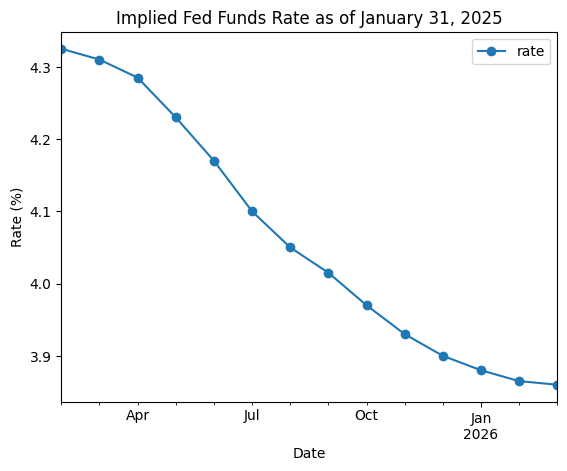

In [129]:
ax = iFFR_jan_31.plot(linestyle='-', marker='o')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.title('Implied Fed Funds Rate as of January 31, 2025')
plt.show()

In [130]:
# January 26
date1 = '2024-07-29'
date2 = '2025-01-26'
date3 = '2025-01-31'

filepath_rawdata2 = f'../data/fedfutures_2025-01-31.xlsx'
data_FFfut = pd.read_excel(filepath_rawdata2, sheet_name=date2).set_index('last_tradeable_dt')
data_FFfut['rate'] = 100-data_FFfut['px_last']

iFFR_jan_26 = data_FFfut[['rate']]
iFFR_jan_26

,rate
last_tradeable_dt,
2025-02-28,4.325
2025-03-31,4.295
2025-04-30,4.245
2025-05-30,4.190
2025-06-30,4.125
2025-07-31,4.045
2025-08-29,3.995
2025-09-30,3.960
2025-10-31,3.915


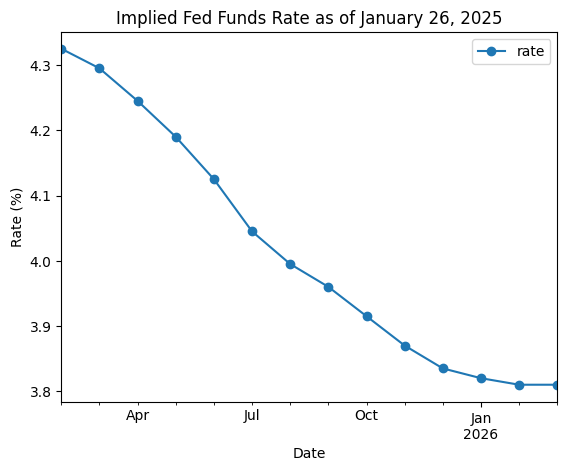

In [131]:
ax = iFFR_jan_26.plot(linestyle='-', marker='o')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.title('Implied Fed Funds Rate as of January 26, 2025')
plt.show()

### 2.2 Extracting the Expected Path of Fed Funds Rates

Assume the Fed...
* sets the rate exactly at its list of meeting dates.
* does not change the rate betweeen meeting dates.

Use the present data to calculate--and plot--the implied set of expected Fed Funds rates as of each meeting date.

#### Technical Point
* Consider months, $t$, where there is a meeting, but such that in month $t+1$ there is no meeting.
* There will be two reasonable ways to extract the expected fed funds rate:
    1. Use the futures rate from the $t+1$-contract
    2. Calculate the implied rate for the remainder of month $t$, knowing the expected rate at the end of month $t+1$.
* These are both reasonable and will likely not differ much.

Try to make reasonable assumptions as needed. to implement the calculation.

In [132]:
date1 = '2024-07-29'
date2 = '2025-01-26'
date3 = '2025-01-31'

filepath_rawdata2 = f'../data/fedfutures_2025-01-31.xlsx'
data_FFfut = pd.read_excel(filepath_rawdata2, sheet_name=date3)
data_FFfut['implied_rate'] = 100-data_FFfut['px_last']
data_FFfut

,ticker,px_last,last_tradeable_dt,open_int,implied_rate
0,FFG5 Comdty,95.675,2025-02-28,503574,4.325
1,FFH5 Comdty,95.690,2025-03-31,320421,4.310
2,FFJ5 Comdty,95.715,2025-04-30,318741,4.285
3,FFK5 Comdty,95.770,2025-05-30,360361,4.230
4,FFM5 Comdty,95.830,2025-06-30,156189,4.170
5,FFN5 Comdty,95.900,2025-07-31,194301,4.100
6,FFQ5 Comdty,95.950,2025-08-29,70271,4.050
7,FFU5 Comdty,95.985,2025-09-30,46060,4.015
8,FFV5 Comdty,96.030,2025-10-31,52800,3.970
9,FFX5 Comdty,96.070,2025-11-28,28439,3.930


In [133]:
data_fed_meetings

,meeting dates
0,2025-03-19
1,2025-05-07
2,2025-06-18
3,2025-07-30
4,2025-09-17
5,2025-10-29
6,2025-12-10
7,2026-01-29
8,2026-03-18


In [134]:
# Interpolating Rates for Meeting Dates
def extract_fed_funds_path(future_data, meeting_dates_df):
    "future_data: dataframe containing futures, with columns 'last_tradeable_dt' and 'implied_rate'"
    "meeting_dates_df: dataframe containing Fed meeting dates"
    
    # Takes the dates from meeting_dates_df
    meeting_dates = pd.to_datetime(meeting_dates_df['meeting dates'])
    meeting_rates = []
    
    for meeting in meeting_dates:
        # Find the two closest future contract dates
        past_contracts = future_data[future_data['last_tradeable_dt'] <= meeting]
        future_contracts = future_data[future_data['last_tradeable_dt'] > meeting]
        
        if not past_contracts.empty and not future_contracts.empty:
            last_contract = past_contracts.iloc[-1]
            next_contract = future_contracts.iloc[0]
            
            # Linear interpolation for meeting date
            days_between = (next_contract['last_tradeable_dt'] - last_contract['last_tradeable_dt']).days
            days_into_period = (meeting - last_contract['last_tradeable_dt']).days
            
            interpolated_rate = (
                last_contract['implied_rate'] + 
                (next_contract['implied_rate'] - last_contract['implied_rate']) * (days_into_period / days_between)
            )
        elif not past_contracts.empty:
            interpolated_rate = past_contracts.iloc[-1]['implied_rate']
        else:
            interpolated_rate = future_contracts.iloc[0]['implied_rate']
        
        meeting_rates.append({'meeting_date': meeting, 'expected_rate': interpolated_rate})
    
    return pd.DataFrame(meeting_rates)

# Formula Inputs
future_data = data_FFfut
meeting_dates_df = data_fed_meetings

# Compute expected Fed Funds path
expected_fed_funds_path = extract_fed_funds_path(future_data, meeting_dates_df)
expected_fed_funds_path = expected_fed_funds_path.set_index('meeting_date')
expected_fed_funds_path = expected_fed_funds_path.rename(columns={'expected_rate': 'expected_rate_2025'})
expected_fed_funds_path


,expected_rate_2025
meeting_date,
2025-03-19,4.315806
2025-05-07,4.272167
2025-06-18,4.193226
2025-07-30,4.102258
2025-09-17,4.029219
2025-10-29,3.972903
2025-12-10,3.919091
2026-01-29,3.880667
2026-03-18,3.862031


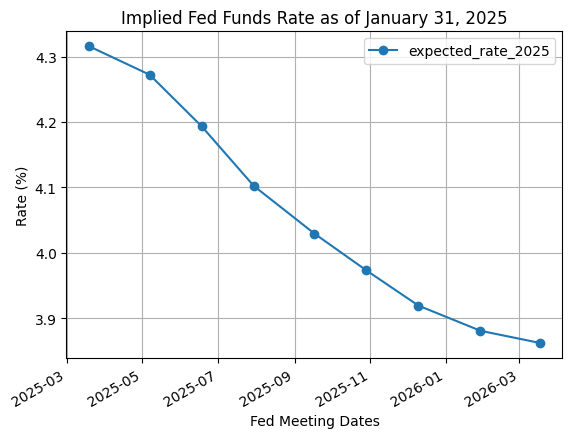

In [135]:
ax = expected_fed_funds_path.plot(linestyle='-', marker='o')

plt.legend()
plt.xlabel('Fed Meeting Dates')
plt.ylabel('Rate (%)')
plt.title('Implied Fed Funds Rate as of January 31, 2025')
plt.grid()
plt.show()

### 2.3 Compare to the Historic Curve

Use the price data in `2024` to extract the expectations at the previous date.
* Note that you do not need to "bootstrap" up from the historic date to the current date. 

Compare this to the answer in the previous problem, for the current data.

In [136]:
date1 = '2024-07-29'
date2 = '2025-01-26'
date3 = '2025-01-31'

filepath_rawdata2 = f'../data/fedfutures_2025-01-31.xlsx'
data_FFfut_2024 = pd.read_excel(filepath_rawdata2, sheet_name=date1)
data_FFfut_2024['implied_rate'] = 100-data_FFfut['px_last']
data_FFfut_2024

,ticker,px_last,last_tradeable_dt,implied_rate
0,FFQ4 Comdty,94.6825,2024-08-30,4.325
1,FFU4 Comdty,94.7900,2024-09-30,4.310
2,FFV4 Comdty,94.9500,2024-10-31,4.285
3,FFX4 Comdty,95.0750,2024-11-29,4.230
4,FFZ4 Comdty,95.2050,2024-12-31,4.170
5,FFF5 Comdty,95.3500,2025-01-31,4.100
6,FFG5 Comdty,95.5150,2025-02-28,4.050
7,FFH5 Comdty,95.6000,2025-03-31,4.015
8,FFJ5 Comdty,95.7300,2025-04-30,3.970
9,FFK5 Comdty,95.8650,2025-05-30,3.930


In [137]:
# Formula Inputs
future_data = data_FFfut_2024
meeting_dates_df = data_fed_meetings

# Compute expected Fed Funds path
expected_fed_funds_path_2024 = extract_fed_funds_path(future_data, meeting_dates_df)
expected_fed_funds_path_2024 = expected_fed_funds_path_2024.set_index('meeting_date')
expected_fed_funds_path_2024 = expected_fed_funds_path_2024.rename(columns={'expected_rate': 'expected_rate_2024'})
expected_fed_funds_path_2024

,expected_rate_2024
meeting_date,
2025-03-19,4.028548
2025-05-07,3.960667
2025-06-18,3.911613
2025-07-30,3.880645
2025-09-17,3.862031
2025-10-29,3.860000
2025-12-10,3.860000
2026-01-29,3.860000
2026-03-18,3.860000


In [138]:
expected_fed_funds_path['expected_rate_2024'] = expected_fed_funds_path_2024.values
expected_fed_funds_path

,expected_rate_2025,expected_rate_2024
meeting_date,,
2025-03-19,4.315806,4.028548
2025-05-07,4.272167,3.960667
2025-06-18,4.193226,3.911613
2025-07-30,4.102258,3.880645
2025-09-17,4.029219,3.862031
2025-10-29,3.972903,3.860000
2025-12-10,3.919091,3.860000
2026-01-29,3.880667,3.860000
2026-03-18,3.862031,3.860000


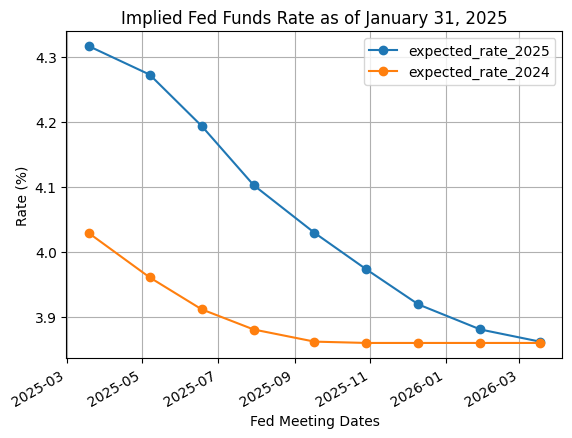

In [139]:
ax = expected_fed_funds_path.plot(linestyle='-', marker='o')

plt.legend()
plt.xlabel('Fed Meeting Dates')
plt.ylabel('Rate (%)')
plt.title('Implied Fed Funds Rate as of January 31, 2025')
plt.grid()
plt.show()

There was a rate hike in 2025. Thus, we can see the jump in rate expectation between 2024 to 2025. In 2025, markets were implying higher rates due to the rate hike that occured.

***